### Import and Loss

In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datas import *
from set_train import *
from utils import *
from utils_test import *
from models.ConformerResnet import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
short = False
stock_symbol, end_date, num_class, batch_size, init, fp16_training, num_epochs, lr = set_train()
trainloader, validloader, testloader, test_date, df = data(stock_symbol, num_class, end_date, batch_size, window=100)
model = Conformer_Resnet(num_class).to(device)
Model = model.model_type
torch.cuda.empty_cache()

100%|██████████| 2863/2863 [00:07<00:00, 370.66it/s]


x_train_len: 2543, valid_len: 160, test_len: 160


### Loss Result


3.837934124469757


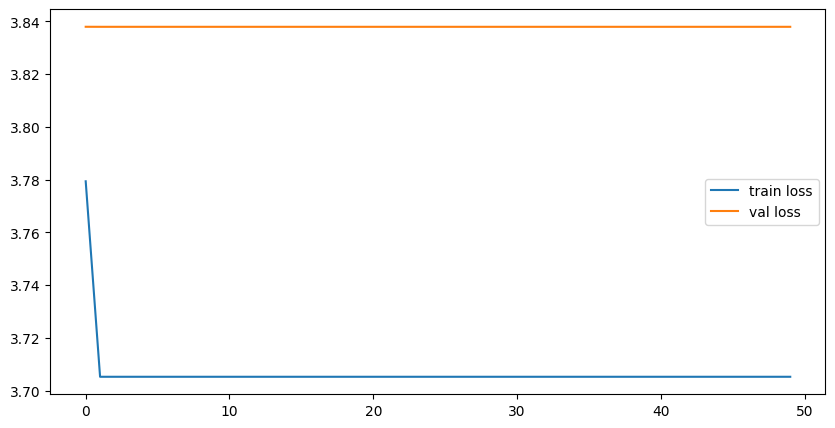

In [2]:
with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_LastTrainInfo.pk', 'rb') as f:
    infos = pickle.load(f)
    print(infos['min val loss'])

with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_TrainValHistLoss.pk', 'rb') as f:
    results = pickle.load(f)
    train_loss = results['train']
    val_loss = results['valid']
    
with open('Model_Result/min_loss.json', 'a') as file:
    import json
    json.dump({f'{Model}_class{num_class}_{stock_symbol}': infos['min val loss']}, file)
    file.write('\n')
    
plt.figure(figsize=(10, 5))
plt.plot(train_loss[:], label='train loss')
plt.plot(val_loss[:], label='val loss')
plt.legend()
plt.savefig(f'Model_Result/{Model}_class{num_class}_{stock_symbol.split(".")[0]}_loss')
plt.show()


### Data

In [3]:
pass

### Backtest

In [4]:
def backtest_plot(normalize=False):
    
    # Prediction
    model.load_state_dict(torch.load(f'Model_Result/{Model}_class{num_class}_{stock_symbol}_best_model.pt'))
    model.eval()    
    y_pred, acc = test(model, testloader)
    y_train_pred, acc = test(model, validloader)
    y_pred_numpy = y_pred.cpu().numpy()
    prediction = pd.DataFrame(y_pred_numpy)
        
    # Scaling with predicted valid set
    if normalize:
        y_train_numpy = y_train_pred.detach().cpu().numpy()
        scaler = StandardScaler()
        scaler.fit(y_train_numpy)
        prediction = pd.DataFrame(scaler.transform(prediction))
        
    # Column name
    if num_class == 1:
        prediction.columns = ['pred_doc_1']
    else:
        prediction.columns = ['pred_do_1', 'pred_dc_1']

    # Merge on date. 
    #   In Encoder Decoder need to ignore the last batch if last batch's batch size != batch_size
    #   so use date_test[:len(prediction)]
    prediction['Date'] = test_date[:len(prediction)]
    true_and_pred = pd.merge(df.reset_index(), prediction, on = 'Date', how = 'left')
    
    # Close is normalised while use Close in training, set Close to original
    true_and_pred['Close'] = true_and_pred['Close_origin']
    
    # Get the predicted doc_1. If class == 1 the the y_pred is the doc_1
    """
    NOTE:
    1. Use today's data predict tmr's
    2. y is y * 100. /= 100 here
    3. d~ is all percentile change
    """
    if num_class == 2:
        true_and_pred['pred_o'] = (true_and_pred['Open'] * (1 + true_and_pred['pred_do_1']))
        true_and_pred['pred_c'] = (true_and_pred['Close'] * (1 + true_and_pred['pred_dc_1']))
        true_and_pred['pred_doc_1'] = \
            (true_and_pred['pred_c'] - true_and_pred['pred_o'])/true_and_pred['pred_o']
    elif num_class == 1:
        pass
    true_and_pred['doc_1'] /= 100
    true_and_pred['pred_doc_1'] /= 100
    
    # Backtest
    asset = 1
    asset_buyhold = 1
    asset_list = []
    thres = 0 if normalize else 0.00
    if num_class == 2:
        df_backtest = true_and_pred[['Open', 'Close', 'doc_1', 'pred_doc_1', 'pred_do_1', 'pred_dc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        asset = 1
        asset_buyhold = 1
        for index, (o, c, true, pred, _, _) in df_backtest.iterrows():
            if pred > thres:
                asset *= (1 + true)   
            if short and pred < -thres:
                asset *= (1 - true)   
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
    elif num_class == 1:
        df_backtest = true_and_pred[['Close', 'pred_doc_1', 'doc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        asset = 1
        asset_buyhold = 1
        for index, (c, pred, true) in df_backtest.iterrows():
            # print(pred, true)
            if pred > thres:
                asset *= (1 + true)
            if short and pred < -thres:
                asset *= (1 - true)
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
        print(f'Buy Hold last asset: {asset_buyhold}')

    print(f'Asset: {asset}')
    plt.plot(asset_list, label = 'model')
    plt.plot(df_backtest.reset_index()['Close']/df_backtest['Close'].iloc[0], label = 'buy hold')
    plt.legend()
    plt.savefig(f'Model_Result/{Model}_class{num_class}_{stock_symbol.split(".")[0]}_backtest')   
    return y_pred, df_backtest

100%|██████████| 10/10 [00:00<00:00, 26.53it/s]


Asset: 0.979245403995574


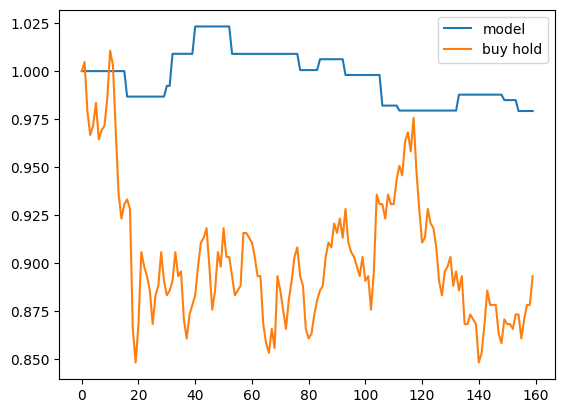

In [5]:
y_pred, df_b = backtest_plot()
torch.cuda.empty_cache()

In [6]:
df_b

,Open,Close,doc_1,pred_doc_1,pred_do_1,pred_dc_1
2802,203.694111,200.370438,0.000000,-0.001312,0.283171,0.133299
2803,201.320068,201.320068,-0.021327,-0.000692,0.240172,0.154324
2804,200.370450,196.097137,-0.004878,-0.000606,0.218911,0.170046
2805,194.672707,193.723083,0.000000,-0.000721,0.294617,0.207115
2806,194.672699,194.672699,0.007282,-0.001782,0.296491,0.065425
...,...,...,...,...,...,...
2957,173.500000,172.500000,0.014535,-0.001146,0.293364,0.151810
2958,172.000000,174.500000,0.008596,-0.000042,0.332387,0.307795
2959,174.500000,176.000000,0.005714,-0.000707,0.282596,0.181733
2960,175.000000,176.000000,0.014164,-0.000813,0.338482,0.222693


In [7]:
stock_symbol.split('.')[0]

'5871'